In [1]:
# % matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib          import rc 
from matplotlib          import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [2]:
def Likelihood(x,mu,std):
    return 1/np.sqrt(2*np.pi*std**2)*np.exp(-(x-mu)**2/(2*std**2))

mu = 0.2
sigma = 0.1
delta = 0.5

n = 10000
x = np.zeros(n)
x[0] = 0

accept = 0

for i in range(0,n-1):
    
    y = x[i] + np.random.uniform(-delta,delta)
    
    if np.random.rand() < np.minimum( 1., Likelihood(y,mu,sigma)/Likelihood(x[i],mu,sigma) ):
        
        x[i+1] = y
        accept += 1
        
    else:
        x[i+1] = x[i]
        
print(accept/float(n)*100)

31.430000000000003


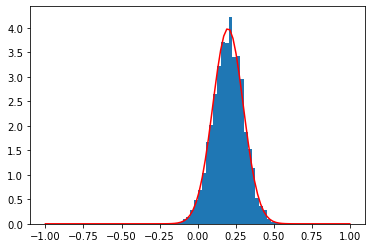

In [3]:
plt.hist(x, density=True, bins=30)
x = np.linspace(-1,1,100)
plt.plot(x,Likelihood(x,mu,sigma),color='r')

# Modelo de Ajuste

Definimos un modelo matemático para ajustar los datos. La función depende de la variable $x$ y de dos parámetros de ajuste $m$ y $b$.

$$ Y_{fit} = mx + b $$

## Función de Costo

Para cuantificar el nivel de acuerdo entre los datos observados y el modelo usamos una función de costo:

$$  \chi^{2}(m,b) = \sum_{i = 0}^{N} \frac{ \left (Y_{Obs,i} - Y_{fit}\right)^{2} }{2\sigma_{i}^{2}}$$
$$  \chi^{2}(m,b) = \sum_{i = 0}^{N} \frac{ \left (Y_{Obs,i} - (m X_{i}+b)\right)^{2} }{2\sigma_{i}^{2}}$$

In [22]:
file_ = 'data/MC.dat'
data = np.loadtxt(file_, comments='#')

X = data[:,0]
print(X)
YObs = data[:,1]

Sigma = np.ones((len(X)))

[0. 1. 2. 3. 4. 5.]


In [5]:
print(data, Sigma)

[[ 0.       8.     ]
 [ 1.       6.4    ]
 [ 2.       3.14159]
 [ 3.       1.5707 ]
 [ 4.       0.     ]
 [ 5.      -1.5    ]] [1. 1. 1. 1. 1. 1.]


No handles with labels found to put in legend.


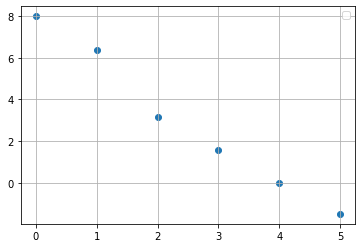

In [6]:
plt.scatter(X,YObs)
plt.grid()
plt.legend(loc=0)

In [7]:
def Model(x,m,b):
    return m*x+b

m1, b1 = -1,4
m2, b2 = -3,8
m2, b2 = -1.96,7.87

Xtest = np.linspace(0.,6.,30)
Y1fit = Model(Xtest, m1, b1)
Y2fit = Model(Xtest, m2, b2)

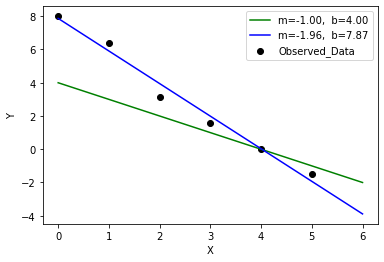

In [8]:
plt.scatter(X, YObs, c='k' ,label="Observed_Data")
plt.plot(Xtest, Y1fit, c='g', label=r"m=%.2f,  b=%.2f" %(m1,b1))
plt.plot(Xtest, Y2fit, c='b', label=r"m=%.2f,  b=%.2f" %(m2,b2))

plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc=0)
plt.show()

In [9]:
def Chi2(m,b):
    Y_fit = Model(X,m,b)
    
    chi2 = 0.
    
    for i in range(len(X)):
        chi2 += (YObs[i]-Y_fit[i])**2/(2*Sigma[i]**2)
    
    return chi2

In [10]:
print(Chi2(m1,b1),Chi2(m2,b2))

14.719463109050002 0.6360696090500008


In [24]:
Chi2 = np.vectorize(Chi2)

m1_ = np.linspace(-5,0,100)
b1_ = np.linspace(0.,10.,100)

m_, b_ = np.meshgrid(m1_,b1_)
z_ = Chi2(m_,b_)
print(z_)

[[796.74974311 782.43123851 768.25302571 ...  61.05344996  60.34325063
   59.77334311]
 [787.42557546 773.18359367 759.08190367 ...  59.15199428  58.51831775
   58.02493304]
 [778.16262606 763.99716707 749.97199988 ...  57.31175684  56.75460312
   56.33774121]
 ...
 [177.33762101 170.44182838 163.68632755 ... 161.64438877 168.35690141
  175.20970586]
 [173.95162294 167.13235311 160.45337509 ... 165.68110266 172.47013811
  179.39946536]
 [170.62684311 163.88409608 157.28164086 ... 169.7790348  176.64459305
  183.65044311]]


<a list of 16 text.Text objects>

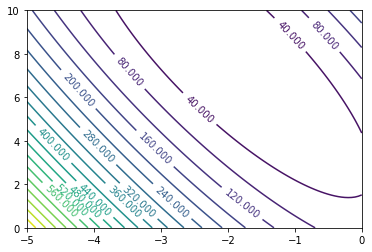

In [12]:
fig, ax = plt.subplots()
c = ax.contour(m_,b_,z_,20)

ax.clabel(c, inline=1, fontsize=10)

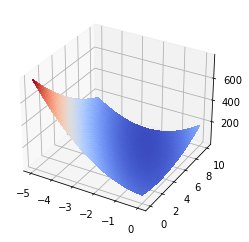

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(m_, b_, z_, cmap=cm.coolwarm ,linewidth=0, antialiased=False)

In [14]:
ii = np.where(z_ == np.amin(z_))

zmin_ = z_[ii][0]

print(zmin_, ii)

0.6359945323741505 (array([78], dtype=int64), array([60], dtype=int64))


In [15]:
bmin, mmin = b1_[ii[0]][0], m1_[ii[1]][0]

print(bmin,mmin)

7.878787878787879 -1.9696969696969697


# Metropolis Hastings algorithm

Hacemos una comparasión ($\alpha$) para decidir si damos el paso de $x_{0}$ a $x_{n}$
$$ \alpha = \frac{\pi(x_{n})}{\pi(x_{0})} $$

Generamos $x_{n} = x_{o}\Delta r(-1, 1)$, donde $r$ es un número aleatorio entre -1 y 1. Para nuestro problema de dos parámetros tenemos: $m_{n} = m_{o}\Delta r(-1, 1)$, $b_{n} = b_{o}\Delta r(-1, 1)$ 

$$ \alpha = \frac{\exp(-\chi^2(m_n, b_n))}{\exp(-\chi^2(m_o, b_o))}$$

In [16]:
def Metropolis(m0_,b0_, WidthSteps, NSteps):
    
    mcmc_steps = []
    
    burn_steps = 5000
    
    for i in tqdm(range(NSteps)):
        
        # Present
        P0 = np.exp(-Chi2(m0_,b0_))
        
        mn_ = m0_ + WidthSteps*2.*(np.random.rand()-0.5)
        bn_ = b0_ + WidthSteps*2.*(np.random.rand()-0.5)
        
        Pn = np.exp(- Chi2(mn_,bn_))
        
        alpha = Pn/P0
        
        beta = np.random.rand()
        
            
        if np.minimum(1, alpha > beta):
                
            m0_ = mn_
            b0_ = bn_
                
        if (i >= burn_steps):
            mcmc_steps.append([m0_,b0_]) 
        
        else:
            if (i >= burn_steps):
                mcmc_steps.append([m0_,b0_])  
    
    
    mcmc_steps = np.array(mcmc_steps)
    return mcmc_steps

In [17]:
mcmc = Metropolis(3.,0.1,0.3,50000)

100%|██████████| 50000/50000 [00:06<00:00, 7298.14it/s]


In [18]:
#print(mcmc)

In [19]:
M = mcmc[:,0]
B = mcmc[:,1]

Text(0, 0.5, '$b$')

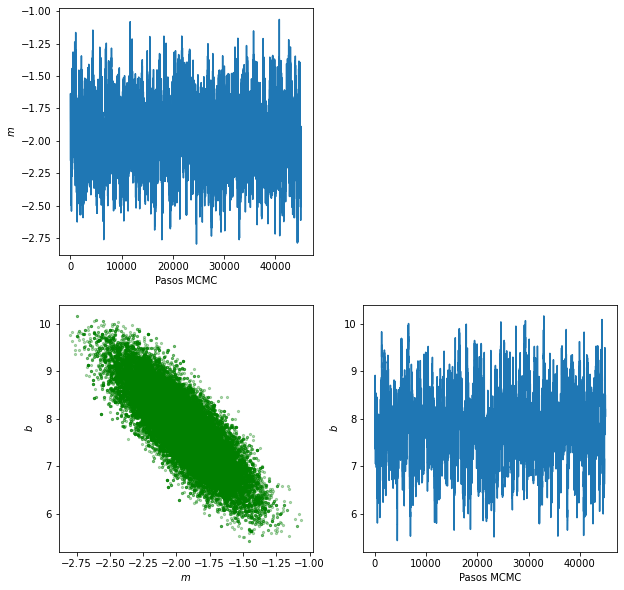

In [20]:
fig = plt.figure( figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(M)
ax1.set_xlabel("Pasos MCMC")
ax1.set_ylabel(r'$m$')

ax3.scatter(M, B, c='g',marker='o', s=5, alpha=0.3)
ax3.set_xlabel(r'$m$')
ax3.set_ylabel(r'$b$')

ax4.plot(B)
ax4.set_xlabel("Pasos MCMC")
ax4.set_ylabel(r'$b$')

AttributeError: 'QuadMesh' object has no property 'normed'

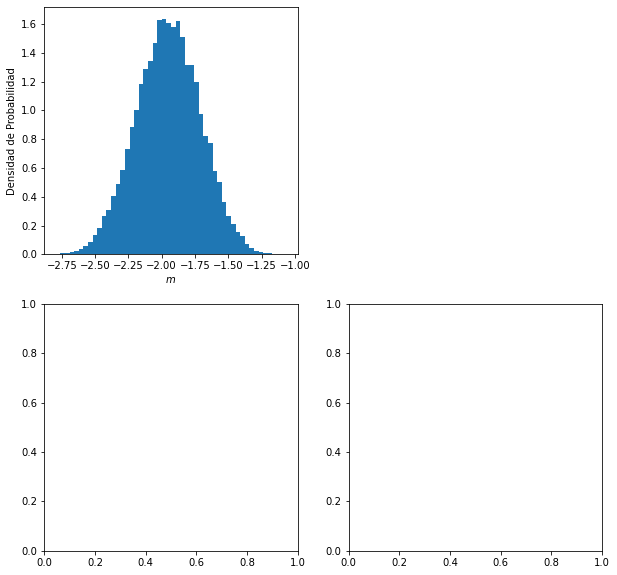

In [21]:
fig = plt.figure( figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.hist(M, 50, density=True)
ax1.set_ylabel('Densidad de Probabilidad')
ax1.set_xlabel(r'$m$')

ax3.hist2d(M, B, bins=40, normed=False, cmap='plasma')
ax3.set_xlabel(r'$m$')
ax3.set_ylabel(r'$b$')

ax4.hist(B, 50, density=True)
ax4.set_ylabel('Densidad de Probabilidad')
ax4.set_xlabel(r'$b$')
#ax4.set_yscale('log')

In [ ]:
mean_ = []

for i in range(2):
    mean=np.percentile(mcmc[:,i],50)
    sigma1 = np.percentile(mcmc[:,i], 16.)
    sigma2 = np.percentile(mcmc[:,i], 84.)
    mean_.append(mean)
    print(mean, sigma2-mean, mean-sigma1)

$$ \hat{m} = -1.95_{-0.24}^{+0.25} $$ 
$$ \hat{b} = 7.84_{-0.74}^{+0.79} $$ 

In [ ]:
plt.scatter(X, YObs, label="Datos Observados")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()

m_estimated = mean_[0]
b_estimated = mean_[1]

Xtest = np.linspace(0.,6.,30)
Yfit = Model(Xtest, m_estimated, b_estimated)

YfitUp = Model(Xtest, m_estimated, b_estimated+0.87)
YfitDown = Model(Xtest, m_estimated, b_estimated-0.67)

plt.plot(Xtest, Yfit, c='r', label=r"$m_1= {:.2f}$, $b_1={:.2f}$".format(m_estimated, b_estimated))
plt.plot(Xtest, YfitUp, c='g')
plt.plot(Xtest, YfitDown, c='g', label=r'Certeza $68\%$')

plt.legend(loc=0)
plt.show()